In [1]:
%load_ext autoreload
%autoreload 2

import logging
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import os
import pandas
import pickle
import scanpy.api as sc
import scipy
import seaborn as sns
from sklearn import decomposition
import tcellmatch.api as tm
import time
import umap

indir = '.'
clonotype_dir = '.'
figir = '.'
fn_blosum = '.'

sc.logging.print_version_and_date()
sc.settings.verbosity = 3
sc.settings.figir = figir

/Users/david.fischer/miniconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


Running Scanpy 1.4.4.post1, on 2019-12-12 14:31.


In [2]:
import matplotlib.pylab as pylab
params = {
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large'
}
pylab.rcParams.update(params)

This notebook contains an example single-cell analysis centric workflow that contains doublet and ambient TCR sequence detection and specificty imputation based on the TcellMatch model.

This notebook creates the panels:
    - Fig. 3a,b,c,d
    - Supp. Fig. 1a,b,c,d,e,f

# Read data

In [3]:
adata_all = sc.read_h5ad(indir + "adata_all.h5ad")

In [4]:
adata1 = sc.read_h5ad(indir + "adata1.h5ad")
adata2 = sc.read_h5ad(indir + "adata2.h5ad")
adata3 = sc.read_h5ad(indir + "adata3.h5ad")
adata4 = sc.read_h5ad(indir + "adata4.h5ad")

In [5]:
def read_clonotypes(fn):
    clonotype_table = pandas.read_csv(clonotype_dir+fn, sep=",", header=0)
    # Extract TCR sequences:
    raw_tcrs_clono = clonotype_table["cdr3s_aa"].values
    tcr_seqs_clono = [[y.split(':') for y in x.split(';')] for x in raw_tcrs_clono]
    tras_clono = [[y[1] for y in x if y[0] == 'TRA'] for x in tcr_seqs_clono]
    trbs_clono = [[y[1] for y in x if y[0] == 'TRB'] for x in tcr_seqs_clono]
    return raw_tcrs_clono, tras_clono, trbs_clono

# Doublets

## Explore number of alleles per TCR chains

In [6]:
adata_all.obs["is_doublet"] = [str(x) for x in np.logical_and(
    adata_all.obs["n_tra"].values > 1,
    adata_all.obs["n_trb"].values > 1 
)]
adata1.obs["is_doublet"] = [str(x) for x in np.logical_and(
    adata1.obs["n_tra"].values > 1,
    adata1.obs["n_trb"].values > 1 
)]
adata2.obs["is_doublet"] = [str(x) for x in np.logical_and(
    adata2.obs["n_tra"].values > 1,
    adata2.obs["n_trb"].values > 1 
)]
adata3.obs["is_doublet"] = [str(x) for x in np.logical_and(
    adata3.obs["n_tra"].values > 1,
    adata3.obs["n_trb"].values > 1 
)]
adata4.obs["is_doublet"] = [str(x) for x in np.logical_and(
    adata4.obs["n_tra"].values > 1,
    adata4.obs["n_trb"].values > 1 
)]

In [7]:
adata_all.obs["is_doublet_numeric"] = np.logical_and(
    adata_all.obs["n_tra"].values > 1,
    adata_all.obs["n_trb"].values > 1 
)
adata1.obs["is_doublet_numeric"] = np.logical_and(
    adata1.obs["n_tra"].values > 1,
    adata1.obs["n_trb"].values > 1 
)
adata2.obs["is_doublet_numeric"] = np.logical_and(
    adata2.obs["n_tra"].values > 1,
    adata2.obs["n_trb"].values > 1 
)
adata3.obs["is_doublet_numeric"] = np.logical_and(
    adata3.obs["n_tra"].values > 1,
    adata3.obs["n_trb"].values > 1 
)
adata4.obs["is_doublet_numeric"] = np.logical_and(
    adata4.obs["n_tra"].values > 1,
    adata4.obs["n_trb"].values > 1 
)

... storing 'is_doublet' as categorical


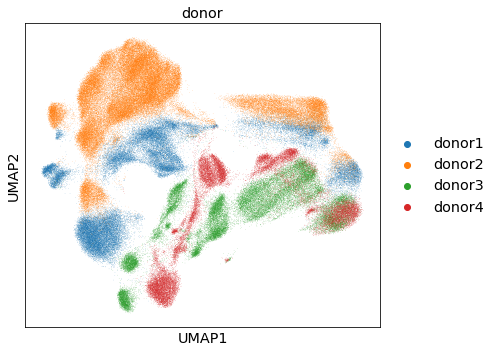

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = sc.pl.umap(adata_all, color=['donor'], cmap="copper", ax=ax, show=False)
plt.tight_layout()
plt.savefig(figir+"supp_1_a.png")
plt.show()

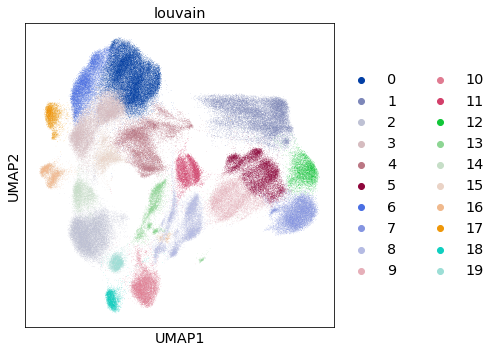

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = sc.pl.umap(adata_all, color=['louvain'], cmap="copper", ax=ax, show=False)
plt.tight_layout()
plt.savefig(figir+"supp_1_b.png")
plt.show()

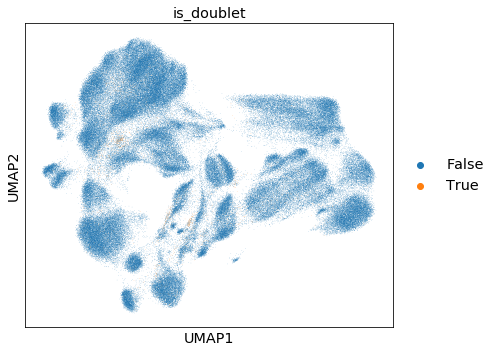

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = sc.pl.umap(adata_all, color=['is_doublet'], cmap="copper", ax=ax, show=False)
plt.tight_layout()
plt.savefig(figir+"supp_1_c.png")
plt.show()

In [11]:
adata_all.obs[["louvain", "is_doublet_numeric"]].groupby(["louvain"]).mean()

,is_doublet_numeric
louvain,
0,0.009296
1,0.008867
2,0.012237
3,0.012336
4,0.011630
5,0.007120
6,0.015238
7,0.004622
8,0.030691


In [12]:
adata_all.obs[["is_doublet_numeric"]].mean()

is_doublet_numeric    0.01401
dtype: float64

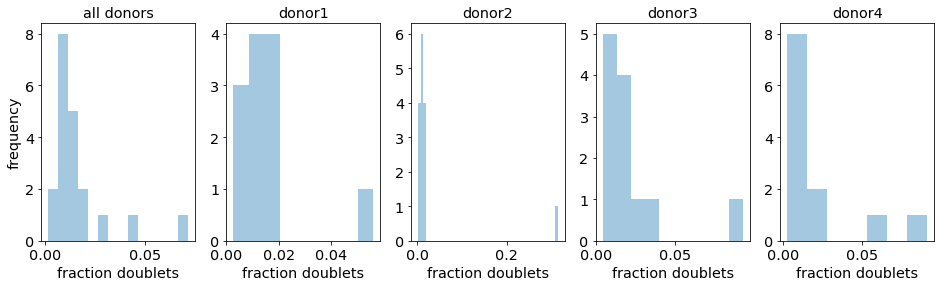

In [13]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4))
sns.distplot(adata_all.obs[["louvain", "is_doublet_numeric"]].groupby(["louvain"]).mean(), kde=False, ax=axs[0])
axs[0].set_title("all donors")
axs[0].set_xlabel("fraction doublets")
axs[0].set_ylabel("frequency")
sns.distplot(adata1.obs[["louvain", "is_doublet_numeric"]].groupby(["louvain"]).mean(), kde=False, ax=axs[1])
axs[1].set_title("donor1")
axs[1].set_xlabel("fraction doublets")
sns.distplot(adata2.obs[["louvain", "is_doublet_numeric"]].groupby(["louvain"]).mean(), kde=False, ax=axs[2])
axs[2].set_title("donor2")
axs[2].set_xlabel("fraction doublets")
sns.distplot(adata3.obs[["louvain", "is_doublet_numeric"]].groupby(["louvain"]).mean(), kde=False, ax=axs[3])
axs[3].set_title("donor3")
axs[3].set_xlabel("fraction doublets")
sns.distplot(adata4.obs[["louvain", "is_doublet_numeric"]].groupby(["louvain"]).mean(), kde=False, ax=axs[4])
axs[4].set_title("donor4")
axs[4].set_xlabel("fraction doublets")
plt.savefig(figir+"supp_1_d.pdf")
plt.show()

## Explore replication of chains across observations: ambient effects

In [14]:
def read_tcrs(adata):
    tcr_seqs = [[y.split(':') for y in x.split(';')] for x in adata.obs["cell_clono_cdr3_aa"].values]
    tras_cell = [[y[1] for y in x if y[0] == 'TRA'] for x in tcr_seqs]
    trbs_cell = [[y[1] for y in x if y[0] == 'TRB'] for x in tcr_seqs]
    return adata.obs["cell_clono_cdr3_aa"].values, tras_cell, trbs_cell

In [15]:
raw_tcr_1, tras_1, trbs_1 = read_tcrs(adata1)
raw_tcr_2, tras_2, trbs_2 = read_tcrs(adata2)
raw_tcr_3, tras_3, trbs_3 = read_tcrs(adata3)
raw_tcr_4, tras_4, trbs_4 = read_tcrs(adata4)

In [16]:
tra_freqs = [
    pandas.Series([xxx for xx in x for xxx in xx]).value_counts()
    for x in [tras_1, tras_2, tras_3, tras_4]
]
trb_freqs = [
    pandas.Series([xxx for xx in x for xxx in xx]).value_counts()
    for x in [trbs_1, trbs_2, trbs_3, trbs_4]
]

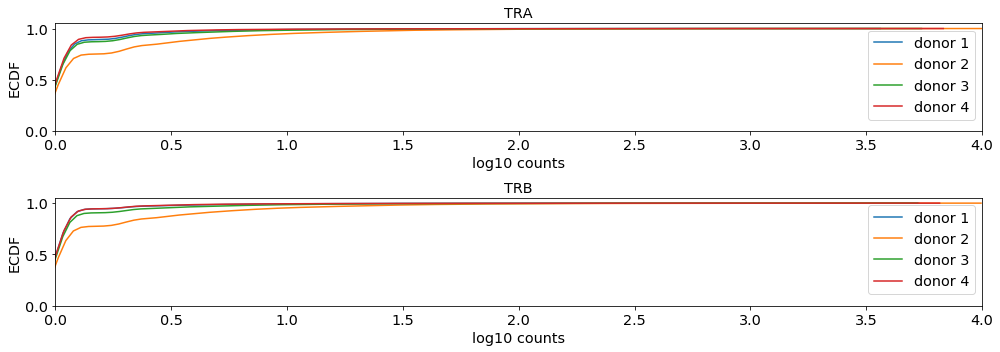

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(14, 5))
for i, x in enumerate(tra_freqs):
    sns.distplot(
        a=np.log(x.values.astype(float)) / np.log(10),
        label="donor "+str(i+1),
        hist=False, kde=True,
        kde_kws=dict(bw=0.05, cumulative=True),
        ax=axs[0]
    )
axs[0].set_xlabel('log10 counts')
axs[0].set_ylabel('ECDF')
axs[0].set_title('TRA')
axs[0].set_xlim([0, 4])

for i, x in enumerate(trb_freqs):
    sns.distplot(
        a=np.log(x.values.astype(float)) / np.log(10),
        label="donor "+str(i+1),
        hist=False, kde=True,
        kde_kws=dict(bw=0.05, cumulative=True),
        ax=axs[1]
    )
axs[1].set_xlabel('log10 counts')
axs[1].set_ylabel('ECDF')
axs[1].set_title('TRB')
axs[1].set_xlim([0, 4])
fig.tight_layout() 
plt.savefig(figir+"supp_1_e.pdf")
plt.show()

### High frequency chains in proposed doublets

Read and assign clonotypes:

In [18]:
raw_tcrs_clono_1, tras_clono_1, trbs_clono_1 = read_clonotypes("vdj_v1_hs_aggregated_donor1_clonotypes.csv")
raw_tcrs_clono_2, tras_clono_2, trbs_clono_2 = read_clonotypes("vdj_v1_hs_aggregated_donor2_clonotypes.csv")
raw_tcrs_clono_3, tras_clono_3, trbs_clono_3 = read_clonotypes("vdj_v1_hs_aggregated_donor3_clonotypes.csv")
raw_tcrs_clono_4, tras_clono_4, trbs_clono_4 = read_clonotypes("vdj_v1_hs_aggregated_donor4_clonotypes.csv")

In [19]:
adata1.obs["clonotype"] = np.array([raw_tcrs_clono_1.tolist().index(x) for x in raw_tcr_1])
adata2.obs["clonotype"] = np.array([raw_tcrs_clono_2.tolist().index(x) for x in raw_tcr_2])
adata3.obs["clonotype"] = np.array([raw_tcrs_clono_3.tolist().index(x) for x in raw_tcr_3])
adata4.obs["clonotype"] = np.array([raw_tcrs_clono_4.tolist().index(x) for x in raw_tcr_4])

Compute TRA and TRB frequency across clonotypes to avoid confounding the definition of ambient sequences as high-frequency chains by large clonotypes.

In [20]:
tra_freqs_clono = [
    pandas.Series([xxx for xx in x for xxx in xx]).value_counts()
    for x in [tras_clono_1, tras_clono_2, tras_clono_3, tras_clono_4]
]
trb_freqs_clono = [
    pandas.Series([xxx for xx in x for xxx in xx]).value_counts()
    for x in [trbs_clono_1, trbs_clono_2, trbs_clono_3, trbs_clono_4]
]

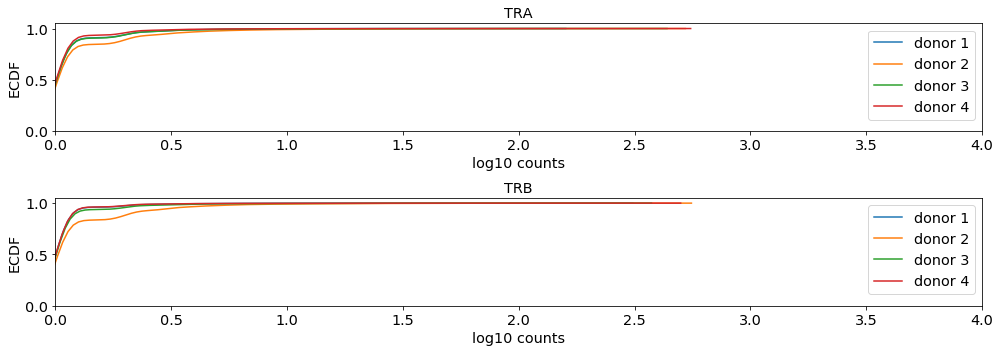

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(14, 5))
for i, x in enumerate(tra_freqs_clono):
    sns.distplot(
        a=np.log(x.values.astype(float)) / np.log(10),
        label="donor "+str(i+1),
        hist=False, kde=True,
        kde_kws=dict(bw=0.05, cumulative=True),
        ax=axs[0]
    )
axs[0].set_xlabel('log10 counts')
axs[0].set_ylabel('ECDF')
axs[0].set_title('TRA')
axs[0].set_xlim([0, 4])

for i, x in enumerate(trb_freqs_clono):
    sns.distplot(
        a=np.log(x.values.astype(float)) / np.log(10),
        label="donor "+str(i+1),
        hist=False, kde=True,
        kde_kws=dict(bw=0.05, cumulative=True),
        ax=axs[1]
    )
axs[1].set_xlabel('log10 counts')
axs[1].set_ylabel('ECDF')
axs[1].set_title('TRB')
axs[1].set_xlim([0, 4])
fig.tight_layout() 
plt.show()

In [22]:
high_freq_threshold = 50

In [23]:
high_freq_tra = [x.index[x.values > high_freq_threshold].tolist() for x in tra_freqs_clono]
high_freq_trb = [x.index[x.values > high_freq_threshold].tolist() for x in trb_freqs_clono]

In [24]:
adata1.obs["tra_high_freq"] = [float(np.any([xx in high_freq_tra[0] for xx in x])) for x in tras_1]
adata2.obs["tra_high_freq"] = [float(np.any([xx in high_freq_tra[1] for xx in x])) for x in tras_2]
adata3.obs["tra_high_freq"] = [float(np.any([xx in high_freq_tra[2] for xx in x])) for x in tras_3]
adata4.obs["tra_high_freq"] = [float(np.any([xx in high_freq_tra[3] for xx in x])) for x in tras_4]

adata1.obs["trb_high_freq"] = [float(np.any([xx in high_freq_trb[0] for xx in x])) for x in trbs_1]
adata2.obs["trb_high_freq"] = [float(np.any([xx in high_freq_trb[1] for xx in x])) for x in trbs_2]
adata3.obs["trb_high_freq"] = [float(np.any([xx in high_freq_trb[2] for xx in x])) for x in trbs_3]
adata4.obs["trb_high_freq"] = [float(np.any([xx in high_freq_trb[3] for xx in x])) for x in trbs_4]

In [25]:
tras_doublet_ambient = pandas.concat([
    pandas.concat([
        pandas.DataFrame({
            "fraction": x.obs.groupby("is_doublet")["tra_high_freq"].mean()[True],
            "doublet": "True",
            "donor": str(i+1)
        }, index=[str(i)]),
        pandas.DataFrame({
            "fraction": x.obs.groupby("is_doublet")["tra_high_freq"].mean()[False],
            "doublet": "False",
            "donor": str(i+1)
        }, index=[str(i)]),
        pandas.DataFrame({
            "fraction": x.obs["tra_high_freq"].values.mean(),
            "doublet": "global",
            "donor": str(i+1)
        }, index=[str(i)])
    ])
    for i, x in enumerate([adata1, adata2, adata3, adata4])
], axis=0)
trbs_doublet_ambient = pandas.concat([
    pandas.concat([
        pandas.DataFrame({
            "fraction": x.obs.groupby("is_doublet")["trb_high_freq"].mean()[True],
            "doublet": "True",
            "donor": str(i+1)
        }, index=[str(i)]),
        pandas.DataFrame({
            "fraction": x.obs.groupby("is_doublet")["trb_high_freq"].mean()[False],
            "doublet": "False",
            "donor": str(i+1)
        }, index=[str(i)]),
        pandas.DataFrame({
            "fraction": x.obs["trb_high_freq"].values.mean(),
            "doublet": "global",
            "donor": str(i+1)
        }, index=[str(i)])
    ])
    for i, x in enumerate([adata1, adata2, adata3, adata4])
], axis=0)

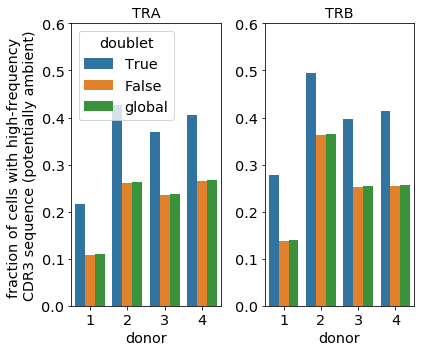

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(6, 5))
sns.barplot(
    data=tras_doublet_ambient,
    x="donor",
    y="fraction",
    hue="doublet",
    ax=axs[0]
)
axs[0].set_xlabel('donor')
axs[0].set_ylabel('fraction of cells with high-frequency \nCDR3 sequence (potentially ambient)')
axs[0].set_ylim([0, 0.6])
axs[0].set_title('TRA')

sns.barplot(
    data=trbs_doublet_ambient,
    x="donor",
    y="fraction",
    hue="doublet",
    ax=axs[1]
)
axs[1].set_xlabel('donor')
axs[1].set_ylabel('')
axs[1].set_ylim([0, 0.6])
axs[1].set_title('TRB')
axs[1].legend_.remove()
fig.tight_layout() 
plt.savefig(figir+"supp_1_f.pdf")
plt.show()

# Antigen specificity across embedding

In [27]:
adata1.obs.columns[:20]

Index(['barcode', 'donor', 'cell_clono_cdr3_aa', 'cell_clono_cdr3_nt', 'CD3',
       'CD19', 'CD45RA', 'CD4', 'CD8a', 'CD14', 'CD45RO', 'CD279_PD-1', 'IgG1',
       'IgG2a', 'IgG2b', 'CD127', 'CD197_CCR7', 'HLA-DR',
       'A0101_VTEHDTLLY_IE-1_CMV', 'A0201_KTWGQYWQV_gp100_Cancer'],
      dtype='object')

## Classify cell types

... storing 'is_doublet' as categorical


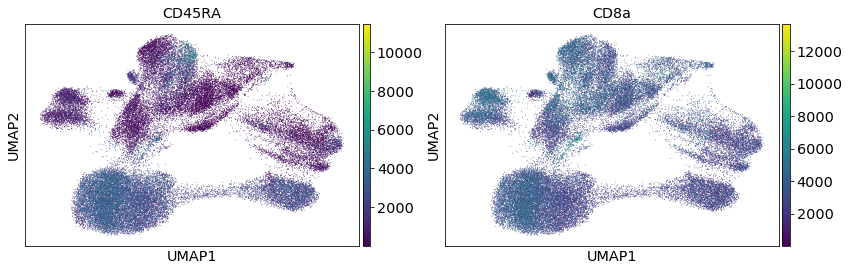

In [28]:
sc.pl.umap(adata1, color=[
    'CD45RA', 'CD8a'
])

## Superimpose observed binding events

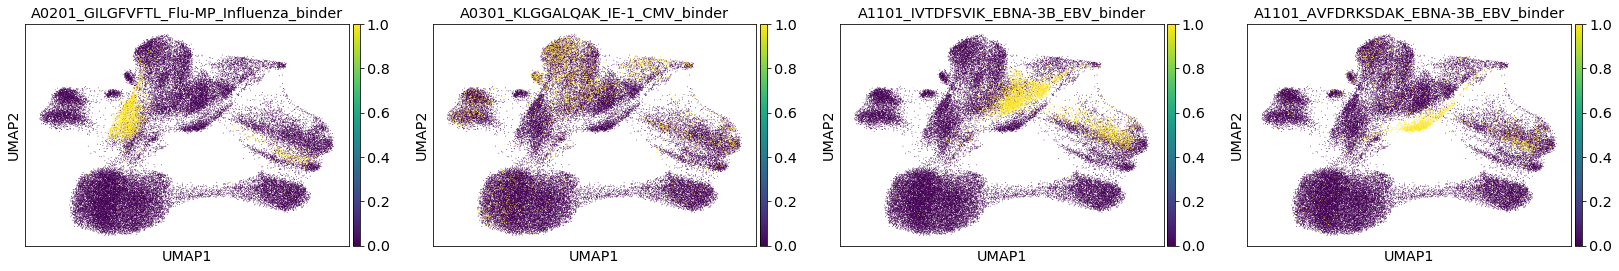

In [29]:
sc.pl.umap(adata1, color=[
    'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
    'A0301_KLGGALQAK_IE-1_CMV_binder',
    'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
    'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder'
])

## Superimpose predicted binding events

In [30]:
def choose_best(indirs, metric="loss", fn_len=19, leave_out_donor=0):
    run_ids = [
        np.sort([
            "_".join(x.split(".")[0].split("_")[:fn_len]) 
             for x in os.listdir(indir+'summaries/') 
             if x.split(".")[1] == "pkl" and x.split(".")[0].split("_")[fn_len-1] == str(leave_out_donor)
        ])
        for indir in indirs
    ]
    results = [np.array([np.load(indir + 'summaries/' + x + "_results.npy") for x in run_ids[i]]) 
               for i, indir in enumerate(indirs)]
    results = np.concatenate(results, axis=0)
    if len(results.shape) == 1:
        results = np.expand_dims(results, axis=1)
    if metric.lower() == "loss":
        idx = np.argmin(results[:, 0])
    else:
        assert False
    best_run = np.concatenate(run_ids)[idx]
    return best_run

## No donor covariates

### Find best model

In [31]:
model_dir = '/Users/david.fischer/phd/data/tcr_supervised/10x_cd8/gridsearches/'
target_model = 's1_linear_cce_1x1'

In [32]:
run_id = choose_best([model_dir + x + '/' for x in [target_model]], leave_out_donor=0, fn_len=19)
print(run_id)

10x_cd8_LINEAR_1X1_S1_CONCAT_CCE_1_1_1_1_2_1_s1_linear_cce_1x1_0_0


### Load and apply model

Load a saved model:

In [33]:
ffn = tm.models.EstimatorFfn()
if False:
    # Use this once all runs saved the full set of settings necessary to re-initialise from scratch with current API.
    ffn.load_model(model_dir + target_model + '/models/' + run_id)
else:
    ffn.load_data(fn=model_dir + target_model + '/models/' + run_id)
    ffn.load_model_settings(fn=model_dir + target_model + '/models/' + run_id)
    ffn.model_hyperparam["label_smoothing"] = 0
    ffn.model_hyperparam["model"] = run_id.split("_")[2].lower()
    ffn.model_hyperparam["optimize_for_gpu"] = False
    ffn.initialise_model_from_settings()
    ffn.load_model_2(fn=model_dir + target_model + '/models/' + run_id, log_dir=figir)
    ffn.clear_test_data()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Read data from adata object into model and run model on this data:

In [34]:
for x in [
    'A0101_SLEGGGLGY_NC',
    'A0101_STEGGGLAY_NC',
    'A0201_ALIAPVHAV_NC',
    'A2402_AYSSAGASI_NC',
    'B0702_GPAESAAGL_NC',
    'NR(B0801)_AAKGRGAAL_NC'
]:
    adata1.obs[x+"_log1p"] = np.log(adata1.obs[x].values + 1)
    
ffn.clear_test_data()  # Need this if cell is re-executed so that test data are not stacked.
ffn.read_tcr_from_adata(
    adata=adata1,
    fn_blosum=fn_blosum,
    blosum_encoding=True,
    covariate_formula_categ=[],
    covariate_formula_numeric=[],
    rename_covariates_for_patsy=True,
    chains=run_id.split("_")[5],
    id_cdr3='cell_clono_cdr3_aa',
    is_train=False
)
ffn.pad_sequence(target_len=80 if run_id.split("_")[5].lower() == "concat" else 40, sequence="tcr")
ffn.predict()
pred = ffn.predictions

Add predictions into adata object:

In [35]:
for i, x in enumerate([
    'A0201_ELAGIGILTV_MART-1_Cancer_binder',
    'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
    'A0201_GLCTLVAML_BMLF1_EBV_binder',
    'A0301_KLGGALQAK_IE-1_CMV_binder',
    'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
    'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
    'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
    'B0801_RAKFKQLL_BZLF1_EBV_binder'
]):
    adata1.obs[x+"_predicted"] = pred[:, i]

Show correlation of predictions and observed data:

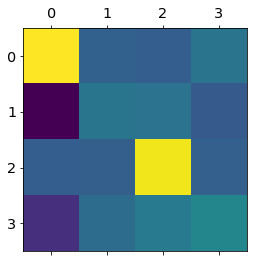

In [36]:
plt.matshow(np.array([
        np.array([
            np.corrcoef(adata1.obs[x].values, adata1.obs[y].values)[0,1]
            for x in [
                'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
                'A0301_KLGGALQAK_IE-1_CMV_binder',
                'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
                'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder'
            ]
        ])
        for y in [
            'A0201_GILGFVFTL_Flu-MP_Influenza_binder_predicted',
            'A0301_KLGGALQAK_IE-1_CMV_binder_predicted',
            'A1101_IVTDFSVIK_EBNA-3B_EBV_binder_predicted',
            'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder_predicted'
        ]
]))
plt.show()

Plot predicted labels on UMAP:

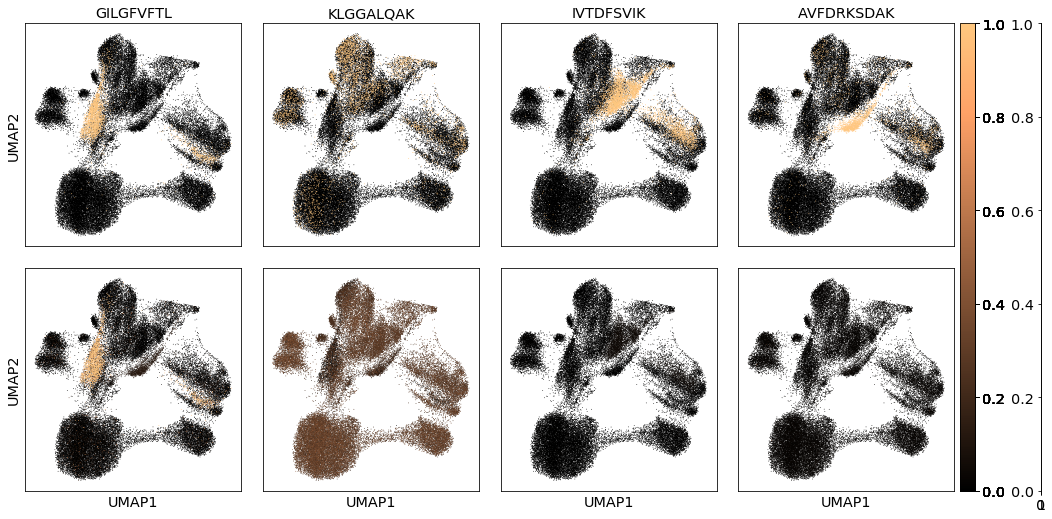

In [37]:
#fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig = plt.figure(figsize=(18.2, 8.6))  # 4*3+3*0.3+1.3, 2*4+2*0.3
axs = ImageGrid(
    fig, 111,
    nrows_ncols=(2, 4),
    axes_pad=0.3,
    share_all=True,
    cbar_location='right',
    cbar_mode='single',
    cbar_size="0.01%",  # need this to hide empty cbar 
    cbar_pad=1.2,  # need this to hide empty cbar 
    aspect = False
)

for i, x in enumerate([
    'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
    'A0301_KLGGALQAK_IE-1_CMV_binder',
    'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
    'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder'
]):
    sc.pl.umap(adata1, color=x, cmap="copper", vmin=0, vmax=1, ax=axs[0+i], show=False)
    axs[0+i].set_title(x.split("_")[1]) # + "_obs")
    axs[0+i].set_xlabel("")
    if i > 0:
        axs[0+i].set_ylabel("")
for i, x in enumerate([
    'A0201_GILGFVFTL_Flu-MP_Influenza_binder_predicted',
    'A0301_KLGGALQAK_IE-1_CMV_binder_predicted',
    'A1101_IVTDFSVIK_EBNA-3B_EBV_binder_predicted',
    'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder_predicted'
]):
    sc.pl.umap(adata1, color=x, cmap="copper", vmin=0, vmax=1, ax=axs[4+i], show=False)
    axs[4+i].set_title("") #x.split("_")[1] + "_pred")
    if i > 0:
        axs[4+i].set_ylabel("")

#plt.tight_layout()
plt.savefig(figir+"main_3_ab.png")
plt.show()

## With covariates

### Find best model

In [38]:
model_dir = '/Users/david.fischer/phd/data/tcr_supervised/10x_cd8/gridsearches/'
target_model_withdonor = 's3_linear_cce_1x1'

In [39]:
run_id_withdonor = choose_best([model_dir + x + '/' for x in [target_model_withdonor]], leave_out_donor=0, fn_len=19)
print(run_id_withdonor)

10x_cd8_LINEAR_1X1_S3_CONCAT_CCE_1_1_1_1_1_1_s3_linear_cce_1x1_0_0


### Load and apply model

Load a saved model:

In [40]:
ffn = tm.models.EstimatorFfn()
if False:
    # Use this once all runs saved the full set of settings necessary to re-initialise from scratch with current API.
    ffn.load_model(model_dir + target_model_withdonor + '/models/' + run_id_withdonor)
else:
    ffn.load_data(fn=model_dir + target_model_withdonor + '/models/' + run_id_withdonor)
    ffn.load_model_settings(fn=model_dir + target_model_withdonor + '/models/' + run_id_withdonor)
    y_test = np.asarray(scipy.sparse.load_npz(file=model_dir + target_model_withdonor + "/summaries/" + run_id_withdonor + "_y_obs.npz").todense())
    ffn.y_train = np.zeros([ffn.x_train.shape[0], y_test.shape[1]])
    ffn.model_hyperparam["optimize_for_gpu"] = False
    ffn.model_hyperparam["model"] = "LINEAR"  # TODO remove
    ffn.model_hyperparam["label_smoothing"] = 0  # TODO remove
    ffn.initialise_model_from_settings()
    ffn.load_model_2(fn=model_dir + target_model_withdonor + '/models/' + run_id_withdonor, log_dir=figir)
    ffn.clear_test_data()

Read data from adata object into model and run model on this data:

In [41]:
for x in [
    'A0101_SLEGGGLGY_NC',
    'A0101_STEGGGLAY_NC',
    'A0201_ALIAPVHAV_NC',
    'A2402_AYSSAGASI_NC',
    'B0702_GPAESAAGL_NC',
    'NR(B0801)_AAKGRGAAL_NC'
]:
    adata_all.obs[x+"_log1p"] = np.log(adata_all.obs[x].values + 1)
ffn.clear_test_data()  # Need this if cell is re-executed so that test data are not stacked.
ffn.read_tcr_from_adata(
    adata=adata_all,
    fn_blosum=fn_blosum,
    blosum_encoding=True,
    covariate_formula_categ=["donor"],
    covariate_formula_numeric=["sf"],
    rename_covariates_for_patsy=True,
    chains=run_id_withdonor.split("_")[5],
    id_cdr3='cell_clono_cdr3_aa',
    is_train=False
)
ffn.pad_sequence(target_len=80 if run_id_withdonor.split("_")[5].lower() == "concat" else 40, sequence="tcr")
ffn.predict()
pred_all = ffn.predictions

Add predictions into adata object:

In [42]:
for i, x in enumerate([
    'A0201_ELAGIGILTV_MART-1_Cancer_binder',
    'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
    'A0201_GLCTLVAML_BMLF1_EBV_binder',
    'A0301_KLGGALQAK_IE-1_CMV_binder',
    'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
    'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
    'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
    'B0801_RAKFKQLL_BZLF1_EBV_binder'
]):
    adata_all.obs[x+"_predicted"] = pred_all[:, i]

Show correlation of predictions and observed data:

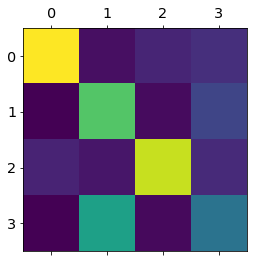

In [43]:
plt.matshow(np.array([
        np.array([
            np.corrcoef(adata_all.obs[x].values, adata_all.obs[y].values)[0,1]
            for x in [
                'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
                'A0301_KLGGALQAK_IE-1_CMV_binder',
                'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
                'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder'
            ]
        ])
        for y in [
            'A0201_GILGFVFTL_Flu-MP_Influenza_binder_predicted',
            'A0301_KLGGALQAK_IE-1_CMV_binder_predicted',
            'A1101_IVTDFSVIK_EBNA-3B_EBV_binder_predicted',
            'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder_predicted'
        ]
]))
plt.show()

Plot predicted labels on UMAP:

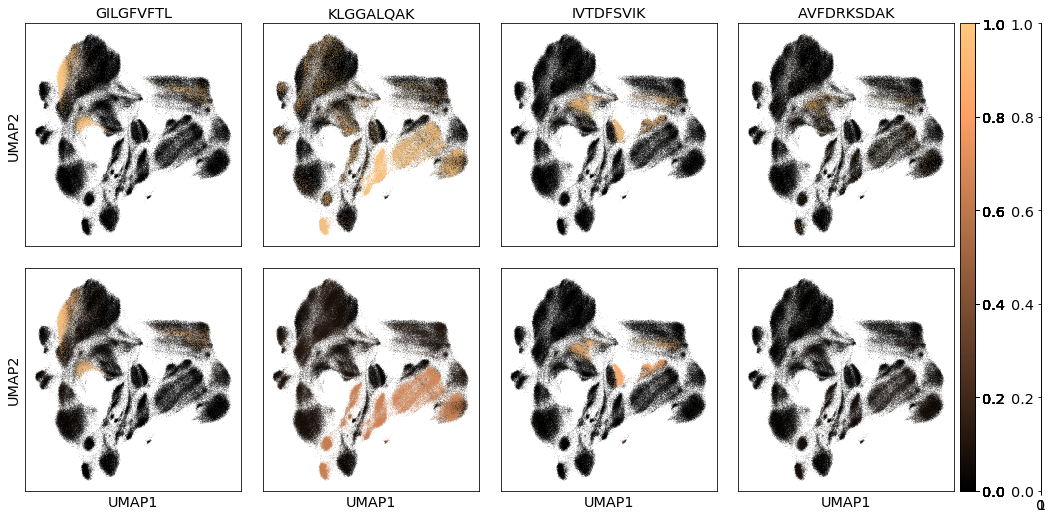

In [44]:
fig = plt.figure(figsize=(18.2, 8.6))  # 4*3+3*0.3+1.3, 2*4+2*0.3
axs = ImageGrid(
    fig, 111,
    nrows_ncols=(2, 4),
    axes_pad=0.3,
    share_all=True,
    cbar_location='right',
    cbar_mode='single',
    cbar_size="0.01%",  # need this to hide empty cbar 
    cbar_pad=1.2,  # need this to hide empty cbar 
    aspect = False
)

for i, x in enumerate([
    'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
    'A0301_KLGGALQAK_IE-1_CMV_binder',
    'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
    'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder'
]):
    sc.pl.umap(adata_all, color=x, cmap="copper", vmin=0, vmax=1, ax=axs[0+i], show=False)
    axs[0+i].set_title(x.split("_")[1]) # + "_obs")
    axs[0+i].set_xlabel("")
    if i > 0:
        axs[0+i].set_ylabel("")
for i, x in enumerate([
    'A0201_GILGFVFTL_Flu-MP_Influenza_binder_predicted',
    'A0301_KLGGALQAK_IE-1_CMV_binder_predicted',
    'A1101_IVTDFSVIK_EBNA-3B_EBV_binder_predicted',
    'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder_predicted'
]):
    sc.pl.umap(adata_all, color=x, cmap="copper", vmin=0, vmax=1, ax=axs[4+i], show=False)
    axs[4+i].set_title("") #x.split("_")[1] + "_pred")
    if i > 0:
        axs[4+i].set_ylabel("")

#plt.tight_layout()
plt.savefig(figir+"main_3_cd.png")
plt.show()